# 1. Import

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from numba import jit

# 2. Preprocessing & Feature EDA

In [2]:
df = pd.read_csv("archive/train.csv")
# df.head()

In [3]:
df=df.drop('policy_id', axis=1)

In [4]:
df['torque'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
df['rpm'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

df['torque'] = pd.to_numeric(df['torque'])
df['rpm'] = pd.to_numeric(df['rpm'])

df['torque_rpm'] = df['torque'] / df['rpm']

In [5]:
df.drop('max_torque', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('torque',axis=1,inplace=True)

In [6]:
df['power'] = df['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
df['rpm'] = df['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

df['power'] = pd.to_numeric(df['power'])
df['rpm'] = pd.to_numeric(df['rpm'])

df['power_rpm'] = df['power'] / df['rpm']

In [7]:
df.drop('power', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('max_power',axis=1,inplace=True)

In [8]:
df = df.replace({ "No" : 0 , "Yes" : 1 })

In [9]:
dataset_num_col = df.select_dtypes(include=['int', 'float', 'bool']).columns

In [10]:
dataset_cat_cols = df.select_dtypes(include=['object']).columns

In [11]:
df= pd.get_dummies(df, columns=dataset_cat_cols,drop_first=True)

In [12]:
df_0 = df[df['is_claim'] == 0].sample(n=5000, random_state=42)
df_1 = df[df['is_claim'] == 1].sample(n=3000, random_state=42)

df = pd.concat([df_0, df_1], ignore_index=True)

In [13]:
df = df.sample(frac=1, random_state=42, ignore_index=True)

In [14]:
_df = df.copy()

In [15]:
def normalize(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

for column in dataset_num_col:
    df[column] = normalize(df[column])

In [16]:
X = df.drop(columns = "is_claim")
y = df["is_claim"]

In [17]:
X_train = np.array(X.iloc[:int(X.shape[0]*0.8), :], dtype='float64')
X_val = np.array(X.iloc[int(X.shape[0]-X.shape[0]*0.2):int(X.shape[0]-X.shape[0]*0.1), :], dtype='float64')
X_test = np.array(X.iloc[-int(X.shape[0]*0.1):, :], dtype='float64')

y_train = np.array(y[:int(X.shape[0]*0.8)], dtype='float64')
y_val = np.array(y[int(X.shape[0]-X.shape[0]*0.2):int(X.shape[0]-X.shape[0]*0.1)], dtype='float64')
y_test = np.array(y[-int(X.shape[0]*0.1):], dtype='float64')

In [18]:
X_train2 = X_train.copy()
X_val2 = X_val.copy()
X_test2 = X_test.copy()

y_train2 = y_train.copy()
y_val2 = y_val.copy()
y_test2 = y_test.copy()

# 1.Kernel Methods in Ensemble Learning:

In [19]:
class Perceptron:
    def __init__(self, lr=0.01, eps=50, gamma = 0.1):
        self.lr = lr
        self.eps = eps
        self.gamma = gamma
        self.w = None
        self.b = None
        self.Training = []
        self.Validation = []

    def fit(self, X_train, X_val, y_train, y_val):
        self.X_train = self.rbf_kernel(X_train, X_train)
        num_samples, num_features = self.X_train.shape
        self.w = np.zeros(num_features)
        self.b = 0

        for ep in tqdm(range(self.eps)):
            y_train_pred = self.predict(X_train)
            acc = self.accuracy(y_train_pred, y_train)
            loss = self.loss(y_train_pred, y_train)
            self.Training.append(loss)
            
            y_val_pred = self.predict(X_val)
            acc_val = self.accuracy(y_val_pred, y_val)
            loss_val = self.loss(y_val_pred, y_val)
            self.Validation.append(loss_val)
            
            dw = (1 / num_samples) * np.dot(self.X_train.T, (y_train_pred - y_train))
            db = (1 / num_samples) * np.sum(y_train_pred - y_train)
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db
        print(f'Perceptron Accuracy: {acc}, Loss: {loss} ')

    def rbf_kernel(self, X1, X2):
        pairwise_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * pairwise_dists)
        
    def predict(self, x):
        x = self.rbf_kernel(x, X_train)
        lm = np.dot(x, self.w) + self.b
        y_pred = self.sigmoid(lm)
        return y_pred
    
    def accuracy(self, y_pred, y_true):
        return np.sum((y_pred > 0.5).astype(int) == y_true) / len(y_true)
    
    def loss(self, y_pred, y_true):
        return np.mean(- (y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15)))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def acc_loss_plot(self):
        plt.plot(self.Training, label='Training', marker='o')
        plt.plot(self.Validation, label='Validation', marker='x')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        
        plt.legend()
        plt.show()

100%|████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.35it/s]


Perceptron Accuracy: 0.62640625, Loss: 0.6602384835970798 


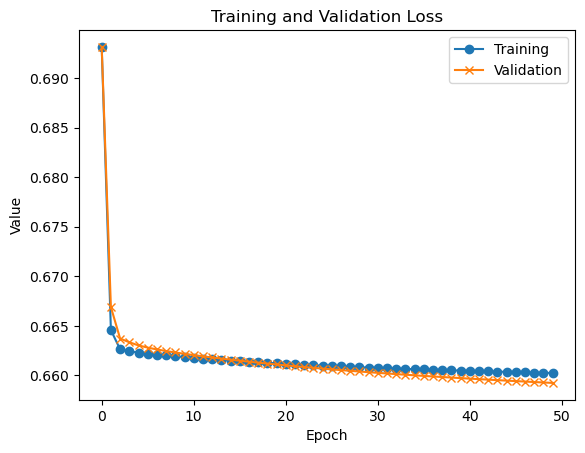

In [20]:
perceptron = Perceptron()
perceptron.fit(X_train, X_val, y_train, y_val)
# Train
y_pred = perceptron.predict(X_train)
accuracy = perceptron.accuracy(y_pred, y_train)
# Val
y_pred = perceptron.predict(X_val)
accuracy = perceptron.accuracy(y_pred, y_val)
perceptron.acc_loss_plot()

In [21]:
gamma = 0.01
pred = list()
model = list()
for i in range(3):
    lm = None
    lm = Perceptron(gamma)
    lm.fit(X_train, X_val, y_train, y_val)
    pred.append(lm.predict(X_test))
    model.append(lm)
    gamma*=0.95
    
# 進行多數決投票
voting_result = np.sum(pred, axis=0)

# 最終預測結果是票數最多的類別
y_pred = np.where(voting_result >= (len(pred) / 2), 1, 0)
acc = model[0].accuracy(y_pred, y_test)
loss = model[0].loss(y_pred, y_test)
print(f'Final Perceptron Accuracy: {acc}, Loss: {loss} ')

100%|████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


Perceptron Accuracy: 0.62640625, Loss: 0.6602384835970798 


100%|████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.29it/s]


Perceptron Accuracy: 0.62640625, Loss: 0.6602934640242256 


100%|████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]

Perceptron Accuracy: 0.62640625, Loss: 0.6603480920567957 
Final Perceptron Accuracy: 0.61125, Loss: 13.426949323521528 


# 2.Ensemble of Deep Learning-Based Non-Tree Weak Learners:

In [22]:
class MLP:
    def __init__(self, in_size, hid_size, out_size):
        self.w1 = np.random.randn(in_size, hid_size)
        self.b1 = np.zeros((1, hid_size))
        self.w2 = np.random.randn(hid_size, out_size)
        self.b2 = np.zeros((1, out_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def fit(self, X, y, lr=0.01, eps=100):
        for ep in range(eps):
            out = self.forward(X)
            loss = self.cross_entropy_loss(out, y)
            self.backward(X, y, out, lr)

            if ep % 100 == 0:
                print(f'Epoch {ep}, Loss: {loss}')

    def cross_entropy_loss(self, out, y):
        m = y.shape[0]
        log_likelihood = -np.log(out[range(m), y.astype(int)])
        return np.sum(log_likelihood) / m

    def backward(self, X, y, out, lr):
        m = y.shape[0]
        dZ2 = out
        dZ2[range(m), y.astype(int)] -= 1
        dZ2 /= m

        dW2 = np.dot(self.a1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dZ1 = np.dot(dZ2, self.w2.T)
        dZ1[self.z1 <= 0] = 0
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.w2 -= lr * dW2
        self.b2 -= lr * db2
        self.w1 -= lr * dW1
        self.b1 -= lr * db1

class DeepRandomForest:
    def __init__(self, num_trees, num_feats, num_inst, num_cls):
        self.num_trees = num_trees
        self.num_feats = num_feats
        self.num_inst = num_inst
        self.num_cls = num_cls
        self.trees = []

    def fit(self, X, y, eps=100):
        for _ in range(self.num_trees):
            sel_feats = np.random.choice(X.shape[1], self.num_feats, replace=False)
            sel_inst = np.random.choice(X.shape[0], self.num_inst, replace=False)
            X_sub = X[sel_inst][:, sel_feats]
            y_sub = y[sel_inst]

            mlp = MLP(self.num_feats, hid_size=64, out_size=self.num_cls)
            mlp.fit(X_sub, y_sub, eps=eps)
            self.trees.append(mlp)

    def predict(self, X):
        preds = np.zeros((X.shape[0], self.num_cls))

        for tree in self.trees:
            tree_out = tree.forward(X[:, :self.num_feats])
            preds += tree_out

        final_preds = preds / self.num_trees
        return (final_preds >= 0.5).astype(int)
    
    def accuracy(self, y_pred, y_true):
        return np.sum(np.argmax(y_pred) == y_true) / len(y_true)

In [23]:
deep_random_forest = DeepRandomForest(num_trees=5, num_feats=10, num_inst=50, num_cls=2)
deep_random_forest.fit(X_train, y_train)
y_test_pred = deep_random_forest.predict(X_test)
acc = deep_random_forest.accuracy(y_test_pred, y_test)
print(f"Final Perceptron Accuracy: {acc}")

Epoch 0, Loss: 6.119890527325464
Epoch 0, Loss: 2.525475893312856
Epoch 0, Loss: 10.718871155951412
Epoch 0, Loss: 4.147299838886433
Epoch 0, Loss: 8.6909452758798
Final Perceptron Accuracy: 0.61125


In [24]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.num_classes = len(set(y))
        self.num_features = X.shape[1]
        self.tree = self._build_tree(X, y)

    def _calculate_gini(self, y):
        m = len(y)
        if m == 0:
            return 0

        gini = 1.0
        for c in range(self.num_classes):
            p = np.sum(y == c) / m
            gini -= p**2

        return gini

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.num_classes)]
        best_gini = 1.0 - sum((n / m) * (num / m)**2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.num_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.num_classes
            num_right = num_parent.copy()

            for i in range(1, m):
                c = int(classes[i - 1])
                num_left[c] += 1.0
                num_right[c] -= 1.0
                gini_left = 1.0 - sum((num_left[x] / i)**2 for x in range(self.num_classes))
                gini_right = 1.0 - sum((num_right[x] / (m - i))**2 for x in range(self.num_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._build_tree(X_left, y_left, depth + 1)
                node.right = self._build_tree(X_right, y_right, depth + 1)

        return node

    def predict(self, X):
        y_pred = np.array([self._predict(inputs) for inputs in X])
        return y_pred

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def accuracy(self, y_pred, y_true):
        return np.sum((y_pred > 0.5).astype(int) == y_true) / len(y_true)

class RandomForest:
    def __init__(self, num_trees, num_feats, num_inst, num_cls):
        self.num_trees = num_trees
        self.num_feats = num_feats
        self.num_inst = num_inst
        self.num_cls = num_cls
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.num_trees):
            sel_feats = np.random.choice(X.shape[1], self.num_feats, replace=False)
            sel_inst = np.random.choice(X.shape[0], self.num_inst, replace=False)
            X_sub = X[sel_inst][:, sel_feats]
            y_sub = y[sel_inst]

            tree = DecisionTreeClassifier()
            tree.fit(X_sub, y_sub)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))

        for tree in self.trees:
            tree_out = tree.predict(X[:, :self.num_feats])
            preds += tree_out

        final_preds = preds / self.num_trees
        return (final_preds >= 0.5).astype(int)
    
    def accuracy(self, y_pred, y_true):
        return np.sum(np.argmax(y_pred) == y_true) / len(y_true)

In [25]:
random_forest = RandomForest(num_trees=5, num_feats=10, num_inst=50, num_cls=2)
random_forest.fit(X_train, y_train)
y_test_pred = random_forest.predict(X_test)
acc = random_forest.accuracy(y_test_pred, y_test)
print(f"Final Perceptron Accuracy: {acc}")

Final Perceptron Accuracy: 0.61125
